In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

# 1. Theoretical Part

Do you want to estimate Potential evaporation but there is a lack of meteorological data in you study area?
Keep reading. There is another formula besides Penman which may be used in this case.

Thornthwaite and Hargreaves approaches are commonly used for the empirical estimation of
evaporation where there is a lack of measured hydrological data and Penman formula cannot be applied. One of their difference is that temporal scale is monthly for Thornthwaite whereas for Hargreaves, it
can be daily or monthly. In this tutorial we will focus on Hargreaves evaporation

The input data are minimum and maximum temperature, and
the geographical latitude of the station. The formula is as follows:

$$
E T_{0}=0.0023 R_{a}\left(\frac{T_{\max }+T_{\min }}{2}+17.8\right) \sqrt{T_{\max }-T_{\min }}
$$

where:

$ET_{o}$: reference evaporation and transpiration ($\frac{MJ}{m^2 d}$), $T_{min}$: minimum temperature ($^oC$), $T_{max}$: maximum temperature ($^oC$), and $R_{a}$: daily extraterrestrial radiation ($\frac{MJ}{m^2 d}$)

Ra is dependent on the geographical latitude of the area and their relationship is negative (lower
geographical locations receive more radiation). Based on Duffie and Beckman (1987), its formula is as
follows:

$$
R_{a}=\frac{1440}{\pi} G_{s} d_{r}\left[\omega_{s} \sin (\phi) \sin (\delta)+\sin \left(\omega_{s}\right) \cos (\phi) \cos (\delta)\right]
$$

where:
    
$G_{s}$: solar constant (0.082 MJ/m2/d), $d_{r}$: inverse relative distance from the Earth to the sun (-), $\delta$:
solar declination angle (rad), $\omega_{s}$: sunset hour angle (rad), $\phi$: well geographical latitude (rad), and J:
number of day in calendar year (from 1 to 365 or 366)

$$
d_{r}=1+0.033 \cos \left(\frac{2 \pi}{365} J\right)
$$

$$
\delta=0.409 \sin \left(\frac{2 \pi}{365} J-1.39\right)
$$

$$
\omega_{s}=\arccos [-\tan (\phi) \tan (\delta)]
$$

The coefficient 0.023 in the first Formula is used to transform the extraterrestrial solar radiation at the
top of the atmosphere to the radiation at the surface of the Earth. An older version of the formula
included the global radiation at the surface of the Earth and not the extraterrestrial radiation but
later the formula changed. The updated formula estimates the global radiation at the surface of the
Earth considering the extraterrestrial radiation and possible sunshine hours based on the geographical
latitude.

# 2. Preprocessing

## 2.1 Maximum Temperature

### 2.1.1 Reading input

In [2]:
byronas_T_max=pd.read_csv('Input_Data/488_max_T_vyronas.txt', skiprows=10, header=None, skipinitialspace=True, names=['date','T_max','Nothing'] , parse_dates=['date'], index_col='date')
byronas_T_max.drop(['Nothing'], axis=1,inplace=True)
byronas_T_max.head()

,T_max
date,
1967-10-01 08:00:00,15.0
1980-04-01 08:00:00,11.0
1980-04-02 08:00:00,11.0
1980-04-03 08:00:00,11.0
1980-04-04 08:00:00,11.0


<AxesSubplot:xlabel='date'>

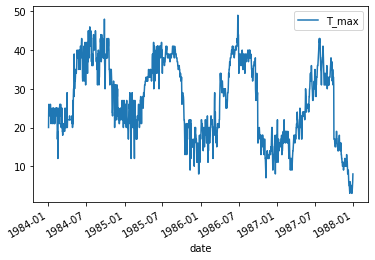

In [3]:
# Selecting data for the period 1984-1987
byronas_T_max_1984_1987 = byronas_T_max.loc["1984-01-01":"1987-12-31"].copy()
byronas_T_max_1984_1987.plot()

In [4]:
byronas_T_max_1984_1987.isnull().sum()

T_max    0
dtype: int64

In [5]:
# this is a function to keep only date from a datetime fiel

def keep_only_date(df):
    df['date'] = df.index
    df['date_only'] = df['date'].dt.date
    df.set_index('date_only', inplace=True)
    df.index.name = 'date'
    df.drop(['date'], inplace=True, axis=1)
    return df

keep_only_date(byronas_T_max_1984_1987)

,T_max
date,
1984-01-01,20.0
1984-01-02,25.0
1984-01-03,26.0
1984-01-04,25.0
1984-01-05,24.0
...,...
1987-12-27,3.0
1987-12-28,4.0
1987-12-29,5.0


### 2.1.2 Fixing missing values

### <font color='blue'> Creating a dataframe of all dates

In [6]:
dates_1984_1987 = pd.date_range(start = "1984-01-01", end="1987-12-31", freq='D')
dates_1984_1987_df = pd.DataFrame(index=dates_1984_1987, data=dates_1984_1987, columns=['date'])
dates_1984_1987.shape

(1461,)

### <font color='blue'> Merge

In [7]:
byronas_T_max_1984_1987.index = byronas_T_max_1984_1987.index.astype('datetime64[ns]')

In [8]:
merge_df_T_max = pd.merge(dates_1984_1987_df, byronas_T_max_1984_1987, how='left', left_on='date', right_index=True)
merge_df_T_max.drop(['date'], axis=1,inplace=True)
merge_df_T_max

,T_max
1984-01-01,20.0
1984-01-02,25.0
1984-01-03,26.0
1984-01-04,25.0
1984-01-05,24.0
...,...
1987-12-27,3.0
1987-12-28,4.0
1987-12-29,5.0
1987-12-30,6.0


### <font color='blue'> Interpolation

In [10]:
merge_df_T_max.T_max.interpolate(method='time', inplace=True)

# 2.2 Minimum Temperature

### 2.2.1 Reading input

In [11]:
byronas_T_min=pd.read_csv('Input_Data/489_min_T_vyronas.txt', skiprows=10, header=None, skipinitialspace=True, names=['date','T_min','Nothing'] , parse_dates=['date'], index_col='date')
byronas_T_min.drop(['Nothing'], axis=1,inplace=True)
byronas_T_min.head()

,T_min
date,
1980-04-01 08:00:00,20.0
1980-04-02 08:00:00,20.0
1980-04-03 08:00:00,20.0
1980-04-04 08:00:00,19.0
1980-04-05 08:00:00,10.0


In [12]:
# Selecting data for the period 1984-2001
byronas_T_min_1984_1987 = byronas_T_min.loc["1984-01-01":"1987-12-31"].copy()
byronas_T_min_1984_1987.isnull().sum()

T_min    0
dtype: int64

In [13]:
keep_only_date(byronas_T_min_1984_1987)

,T_min
date,
1984-01-01,5.0
1984-01-02,-3.0
1984-01-03,0.0
1984-01-04,-2.0
1984-01-05,-2.0
...,...
1987-12-27,-3.0
1987-12-28,1.0
1987-12-29,1.0


### 2.2.2 Fixing missing values

### <font color='blue'> Merge

In [14]:
byronas_T_min_1984_1987.index = byronas_T_min_1984_1987.index.astype('datetime64[ns]')

In [15]:
merge_df_T_min = pd.merge(dates_1984_1987_df, byronas_T_min_1984_1987, how='left', left_on='date', right_index=True)
merge_df_T_min.drop(['date'], axis=1,inplace=True)
merge_df_T_min

,T_min
1984-01-01,5.0
1984-01-02,-3.0
1984-01-03,0.0
1984-01-04,-2.0
1984-01-05,-2.0
...,...
1987-12-27,-3.0
1987-12-28,1.0
1987-12-29,1.0
1987-12-30,1.0


### <font color='blue'>Interpolation

In [16]:
merge_df_T_min.T_min.interpolate(method='time', inplace=True)

# 3. Heargreaves formula estimation

## Creating temperature difference and mean

In [17]:
merge_df = pd.DataFrame()
merge_df['dif'] = merge_df_T_max.T_max - merge_df_T_min.T_min
merge_df['T_avg']= (merge_df_T_max.T_max + merge_df_T_min.T_min) /2

# In case there are negative values 
def negative(i):
    if i<0:
        i=0
    else:
        i
    return i

merge_df['dif'] = merge_df.dif.apply(negative)

## Calculations

In [18]:
merge_df['j'] = merge_df.index.dayofyear
merge_df['dr'] =  1 + 0.033*np.cos(2*np.pi/365* merge_df['j'])
merge_df['delta'] =  0.409 * np.sin(2*np.pi* merge_df['j'] /365 - 1.39)

# provide the geographical latitude of your study area
# You may find it via google maps. If you click on a point, you will see the address, its geographical latitude,
# and longitude
phi = 37.95667
phi_rad = np.deg2rad(phi) # convert it to rad

merge_df['omega_s'] = np.arccos(-1 * (np.tan(phi_rad) * np.tan(merge_df['delta'])))
merge_df['bracket'] = merge_df['omega_s'] *np.sin(phi_rad)*np.sin(merge_df['delta']) + np.sin(merge_df['omega_s'])*np.cos(phi_rad)*np.cos(merge_df['delta'])
merge_df['R_a'] = 1440*0.0820/np.pi*merge_df['dr']*merge_df['bracket']
merge_df['ET'] = 0.0023*merge_df['R_a']* (merge_df.T_avg+17.8)* np.sqrt(merge_df.dif)
# Evaporation = Energy / (ρ * λ)
merge_df['Evap_m'] = merge_df['ET'] / (2.45 * 1000) # output in m/d
merge_df['Evap_mm'] = merge_df['Evap_m'] * 1000 # convert to mm/d

# 4. Plot Evaporation

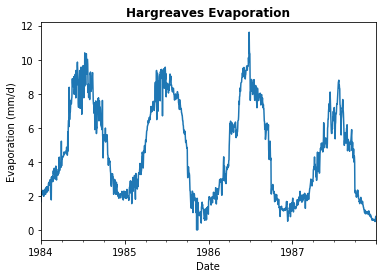

In [19]:
merge_df['Evap_mm'].plot()
plt.xlabel('Date')
plt.ylabel('Evaporation (mm/d)')
plt.title('Hargreaves Evaporation', weight='bold')

# Exporting to Excel
merge_df.to_excel('Output_Data/Hargreaves_Evaporation.xlsx')

# References

Hargreaves, G. H. and Samani, Z. A. (1982). Estimating potential evapotranspiration. Journal of the
irrigation and Drainage Division, 108(3):225-230.

Duffie, J. A. and Beckman, W. A. (1987). Solar engineering of thermal processes. Wiley New York.